In [41]:
from pathlib import Path
import subprocess
from collections import namedtuple
from collections import defaultdict
import gzip
from functools import reduce
from functools import partial
import re
import itertools


# external modules 
import requests
import pandas as pd
from Bio import SeqIO

In [2]:
def cassettes_headers_to_df(multifasta_proteins):
    cmd = ['zgrep', '-Po', '(?<=^\>).+', multifasta_proteins]
    columns = ['contigs', 'cassettes', 'locus_tags', 'headers']
    data = []
    for header in subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines():
        rows = header.split(':')
        assert len(rows) == 3, 'Header {} is invalid !'.format(header)
        rows.append(header)
        data.append(rows)
        
    df = pd.DataFrame(data=data, columns=columns) \
            .assign(genome_ids = lambda x: x['contigs'].str.split(':') \
                .apply(lambda x: '_'.join(x[0].split('_')[1:-1])))
    return df


                
def get_edges(topology: list, drop_duplicates=True):
    edges = []
    for indx, cluster_id in enumerate(topology):
        if indx == 0:
            edges.append((cluster_id, topology[indx+1]))
        elif indx == len(topology) - 1:
            edges.append((cluster_id, topology[indx-1]))
        else:
            edges.append((cluster_id, topology[indx-1]))
            edges.append((cluster_id, topology[indx+1]))
    if not drop_duplicates:
        return edges
    
    strict_edges = []
    for edge in edges:
        if not ( edge in strict_edges or edge[::-1] in strict_edges ):
            strict_edges.append(edge)
    return strict_edges

def get_wanted_locus_tags_from_gbk(gbk_path: str, wanted_locus_tags: list):
    with open(gbk_path) as f:
        features = []
        for record in SeqIO.parse(gbk_path, 'genbank'):
            for feature in filter(lambda fet: fet.qualifiers.get('locus_tag', [None])[0] in wanted_locus_tags, record.features):
                features.append((feature.qualifiers.get('locus_tag', [None])[0], feature))
        return pd.DataFrame(data=features, columns=['locus_tags', 'features'])
    
def list_gbk_files(annotation_dir: str) -> dict:
    cmd = [
        'find',
        annotation_dir,
        '-type', 'f',
        '-name', '*.gbk'
    ]
    files = {}
    for file in subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines():
        file = Path(file)
        genome_id = file.stem.replace('_out', '')
        genome_path = str(file.absolute())
        assert not files.get(genome_id), 'Repeated ids: {}'.format(genome_id)
        files[genome_id] = genome_path
        
    return files

def get_feature_df(genome_filters: list, annotation_dir: str):
    """genome_filter = { genome_id : locus_tags }"""
    genome_paths: dict = list_gbk_files(annotation_dir)
    
    features_df = pd.DataFrame()
    for genome_id, locus_tags in genome_filters.items():
        df = get_wanted_locus_tags_from_gbk(gbk_path=genome_paths[genome_id], wanted_locus_tags=locus_tags)
        if features_df.empty:
            features_df = df
            continue
        features_df = pd.concat([features_df, df])
        
    return features_df.reset_index(drop=True)
        
            
            
def get_feature_string(feature):
    get_qualifier = lambda query: feature.qualifiers.get(query, ['NA'])[0]
    fields = ('gene', 'locus_tag', 'product', 'translation')
    return ';'.join(list(map(lambda field: '='.join((field, get_qualifier(field))) , fields)))


def read_and_merge_predictions(defense_system_prediction_dir: str):
    cmd = [
        'find',
        defense_system_prediction_dir,
        '-type', 'f',
        '-name', '*merged_defense_systems_prediction.csv',
        '!', '-empty'
    ]
    assert Path(defense_system_prediction_dir).exists()
    prediction_files: list = subprocess.run(cmd, check=True, stdout=subprocess.PIPE).stdout.decode('UTF-8').splitlines()
    assert prediction_files, 'No predict file found !'
    read_dataframe = lambda file_path: pd.read_csv(file_path, sep=',')
    
    return pd.concat(map(read_dataframe, prediction_files)).reset_index(drop=True)



## NEW

In [102]:
import requests
import py4cytoscape as p4c

exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client
p4c.cytoscape_ping()
p4c.cytoscape_version_info()


Skip reloading Javascript client ... 27c2754d-4517-46f1-b58b-6e4539806ab5 on https://jupyter-bridge.cytoscape.org
You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.6.0',
 'py4cytoscapeVersion': '1.5.0'}

In [103]:
p4c.create_network_from_data_frames(nodes, edges, title="Salmonella Bacterial Immunity", collection="Salmonella")

Applying default style...
Applying preferred layout


124

In [104]:
p4c.layout_network('kamada-kawai')

{}

In [105]:
style_name = "myStyle"
defaults = {'NODE_SHAPE': "ELLIPSE", 'NODE_SIZE': 10, 'NODE_FILL_COLOR' : '#7b8fba'}
node_labels = p4c.map_visual_property('node label', 'id', 'p') 
node_size_map = p4c.map_visual_property('NODE_SIZE', 'members_count', 'p')
p4c.create_visual_style(style_name, defaults, [node_size_map, node_labels])
p4c.set_visual_style(style_name)

{'message': 'Visual Style applied.'}

In [106]:
p4c.update_style_mapping(style_name, node_size_map)

''

In [107]:
p4c.update_style_mapping(style_name, node_size_map)

''

In [83]:
# Fix sizes (min 10, max 260)
min_size = 20
max_size = 260
factor = 10
p4c.load_table_data(p4c.get_table_columns().assign(members_count  = lambda df: df.members_count.apply(lambda x: min(max_size, max(min_size, factor * x)))).loc[:,['name', 'members_count']].set_index('name', drop=True))

'Success: Data loaded in defaultnode table'

In [67]:
# node_size_map = p4c.map_visual_property('NODE_SIZE', 'members_count', 'p')



In [208]:
# p4c.update_style_mapping(mapping=node_size_map)
# node_size_map
# help(p4c.update_style_mapping)

In [57]:
import re
def get_defense_name(prediction_string: str):
    if prediction_string == 'NA':
        return 'NA'
    
    systems = re.findall('(?<=systems\=).+?(?=\;)', prediction_string)
    
    if not systems:
        return 'NA'
    
    return list(map(lambda x: x.upper().split('_')[0], systems))[0]
    
defense_map_df =  p4c.get_table_columns().set_index('name', drop=True).loc[:,['defense_system_prediction']] \
    .assign(defense_map = lambda df: df.defense_system_prediction.apply(lambda x: get_defense_name(x))).query('defense_map != "NA"') \
    .loc[:, ['defense_map']]

In [58]:
p4c.load_table_data(defense_map_df)

'Success: Data loaded in defaultnode table'

In [59]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('defense_map', mapping_type='d', style_name='default'))

''

,color
defense_map,
DRT,#F9D448
CAS,#D0BDA1
DMS,#B3B3B3
DSR1,#BEA37E
GABIJA,#AB99C8


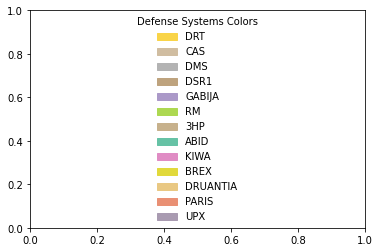

In [65]:
# p4c.get_node_property(visual_property='NODE_FILL_COLOR', node_names=nv1)
# COLORS

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

colors_df = p4c.get_table_columns().loc[:,['id', 'defense_map']].dropna().groupby('defense_map', as_index=False).pipe(lambda df: df.head(1)) \
    .assign(color = lambda df: tuple(map(lambda cluster_id: tuple(p4c.get_node_color(cluster_id).values())[0], df.id.values.tolist()))) \
    .iloc[:, 1:].drop_duplicates().set_index('defense_map', drop=True)

plt.legend(
    handles=[mpatches.Patch(color=color, label=system)  for system, color in colors_df.color.to_dict().items()],
    loc='center', frameon=False, title='Defense Systems Colors'
)
colors_df.head()

In [62]:
min_edge_size = 3
p4c.get_table_columns(table='edge').query('edge_count >= @min_edge_size').head()

,SUID,shared name,shared interaction,name,selected,interaction,source,target,edge_count,data.key.column
2051,2051,IOMDNFNB_00332_yjhB_1 (interacts with) IOMDNFN...,interacts with,IOMDNFNB_00332_yjhB_1 (interacts with) IOMDNFN...,False,interacts with,IOMDNFNB_00332_yjhB_1,IOMDNFNB_00333_NA,10,2051
2054,2054,IOMDNFNB_01075_NA (interacts with) IOMDNFNB_01...,interacts with,IOMDNFNB_01075_NA (interacts with) IOMDNFNB_01...,False,interacts with,IOMDNFNB_01075_NA,IOMDNFNB_01076_dgcQ,10,2054
2057,2057,IOMDNFNB_01076_dgcQ (interacts with) IOMDNFNB_...,interacts with,IOMDNFNB_01076_dgcQ (interacts with) IOMDNFNB_...,False,interacts with,IOMDNFNB_01076_dgcQ,IOMDNFNB_01077_yedP,10,2057
2060,2060,IOMDNFNB_01072_vsr (interacts with) IOMDNFNB_0...,interacts with,IOMDNFNB_01072_vsr (interacts with) IOMDNFNB_0...,False,interacts with,IOMDNFNB_01072_vsr,IOMDNFNB_01073_yedA,10,2060
2063,2063,IOMDNFNB_01077_yedP (interacts with) IOMDNFNB_...,interacts with,IOMDNFNB_01077_yedP (interacts with) IOMDNFNB_...,False,interacts with,IOMDNFNB_01077_yedP,IOMDNFNB_01078_NA,10,2063


In [63]:
p4c.create_column_filter('persistence', 'edge_count', min_edge_size, 'GREATER_THAN_OR_EQUAL', type='edges')
p4c.create_subnetwork(subnetwork_name='Salmonella Bacterial Immunity (filtered min_persistence: {})'.format(str(min_edge_size)))

No nodes selected.


6694

In [5]:
# help(p4c.create_subnetwork)

# 16K genomes

In [4]:
tsv_rep = '/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/mmseqs_cluster.tsv.gz'
all_gffs = '/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/all_csds.gff.gz'
all_GOIs = '/home/hugo/projects/salmonella-bacterial-immunity/net_data_16K/prodigal_with_GOIs.csv.gz'

In [5]:
def tsv_rep_to_df(tsv_rep: str):
    strings_to_remove = ('Contig_', 'Cassette_', 'GOI_', 'Strand_', )
    with gzip.open(tsv_rep) as f:
        rep = None
        for line in iter(map(lambda string: string.decode().strip(), f)):
            cluster, member = line.split('\t')
            cluster =  cluster.split(':')[-1]
            if rep != cluster:
                rep = cluster
            yield (
                cluster,
                *reduce(lambda rec, substr: rec.replace(substr, ''), strings_to_remove, member).split(':'),
            )

clusters_df = pd.DataFrame(tsv_rep_to_df(tsv_rep=tsv_rep), columns=('cluster_rep_locus_tag', 'contigs', 'cassettes', 'is_GOI', 'strand', 'locus_tag'))
clusters_df.head()

,cluster_rep_locus_tag,contigs,cassettes,is_GOI,strand,locus_tag
0,JGKINGID_02763,28901.7257_7,1,False,+,JGKINGID_02763
1,JGKINGID_02763,90370.2301_37,1,False,-,JADHFFOP_02760
2,JGKINGID_02763,590.14785_3,1,False,+,HMFKIHPF_02332
3,JGKINGID_02763,85569.336_1,1,False,+,AEHNPGNC_00428
4,JGKINGID_02763,590.16494_2,1,False,+,IGMGEBKI_01366


In [49]:
rep_prokka_annotation = pd.concat(
    map(lambda df:
        (df.iloc[:, [0,3,4,6,8]]
         .rename(columns=dict(zip((0,3,4,6,8), ('contig_id', 'start', 'end', 'strand', 'feature'))))
         .assign(locus_tag = lambda df: df.feature.apply(lambda feature: dict(map(lambda x: x.split('='), feature.split(';'))).get('locus_tag')))
         .query('locus_tag.isin(@clusters_df.cluster_rep_locus_tag)')),
        pd.read_csv(all_gffs, chunksize=1000, iterator=True, sep='\t', header=None))
)
rep_prokka_annotation.head()

,contig_id,start,end,strand,feature,locus_tag
0,28901.7257_4,124482,125993,-,ID=JGKINGID_01837;eC_number=3.4.11.1;Name=pepA...,JGKINGID_01837
1,28901.7257_4,127488,128570,+,ID=JGKINGID_01839;Name=lptG;db_xref=COG:COG079...,JGKINGID_01839
2,28901.7257_4,128765,129763,-,ID=JGKINGID_01840;Name=gntR_3;gene=gntR_3;infe...,JGKINGID_01840
3,28901.7257_4,133803,134822,-,ID=JGKINGID_01845;eC_number=1.1.1.2;Name=ahr;d...,JGKINGID_01845
4,28901.7257_4,145406,146218,-,ID=JGKINGID_01852;inference=ab initio predicti...,JGKINGID_01852


In [50]:
gcoord = namedtuple('Gcoord', 'strand start end')
is_overlapping = lambda a, b: ( a.strand == b.strand ) and ( max(a.start, b.start) < min(a.end, b.end) )

prodigal_df = pd.concat(map(
    lambda df:
        (df.loc[:, ['locus_tag', 'start', 'end', 'strand', 'prediction']]
         .assign(strand = lambda df: df.strand.apply(lambda x: {-1 : '-', 1 : '+'}.get(x)))
         .assign(contig_id = lambda df: df.locus_tag.apply(lambda x: '_'.join(x.split('_')[:-1])))
         .query('contig_id.isin(@rep_prokka_annotation.contig_id)')
         .drop('locus_tag', axis=1)
         .assign(coords = lambda df: tuple(map(lambda x: gcoord(*x), df.loc[:,['strand', 'start', 'end']].values.tolist())))
         .iloc[:, [-3,-2,-1]]),
    pd.read_csv(all_GOIs, chunksize=1000, iterator=True, sep=';')
)).reset_index(drop=True)
        
prodigal_df.head()

,prediction,contig_id,coords
0,"NA;defensefinder:name=Olokun_OloA,system=Olokun",28901.7369_60,"(+, 7164, 9602)"
1,"NA;defensefinder:name=Olokun_OloB,system=Olokun",28901.7369_60,"(+, 9553, 11025)"
2,"padloc:name=Dsr1,system=dsr1;NA",28901.7369_60,"(-, 11996, 15700)"
3,"padloc:name=mREase_IV,system=RM_type_IV;defens...",28901.7369_97,"(+, 5128, 5961)"
4,"padloc:name=RT_II-A,system=DRT_other;defensefi...",28901.7369_179,"(-, 1625, 2557)"


In [52]:
def get_overlapping(a, coords):
    is_overlapping = lambda a, b: ( a.strand == b.strand ) and ( max(a.start, b.start) < min(a.end, b.end) )
    prediction = coords.get(a)
    
    if prediction:
        return prediction
    
    for b, prediction in coords.items():
        if is_overlapping(a, b):
            return prediction
        
    return 'NA'

rep_prokka_annotation_with_dfs_prediction_df = (rep_prokka_annotation
     .assign(coords = lambda df: tuple(map(lambda x: gcoord(*x), df.loc[:,['strand', 'start', 'end']].values.tolist())))
     .groupby('contig_id', as_index=False)
     .pipe(lambda df: df.apply(lambda df: df.assign( dfs_prediction = df.coords.apply(partial(
         get_overlapping,
         coords=prodigal_df.query('contig_id == @df.contig_id.iloc[0]').loc[:,['prediction', 'coords']].set_index('coords', drop=True).prediction.to_dict())))))
     .drop('coords', axis=1))

rep_prokka_annotation_with_dfs_prediction_df.head()

,contig_id,start,end,strand,feature,locus_tag,dfs_prediction
0,28901.7257_4,124482,125993,-,ID=JGKINGID_01837;eC_number=3.4.11.1;Name=pepA...,JGKINGID_01837,NA
1,28901.7257_4,127488,128570,+,ID=JGKINGID_01839;Name=lptG;db_xref=COG:COG079...,JGKINGID_01839,NA
2,28901.7257_4,128765,129763,-,ID=JGKINGID_01840;Name=gntR_3;gene=gntR_3;infe...,JGKINGID_01840,NA
3,28901.7257_4,133803,134822,-,ID=JGKINGID_01845;eC_number=1.1.1.2;Name=ahr;d...,JGKINGID_01845,NA
4,28901.7257_4,145406,146218,-,ID=JGKINGID_01852;inference=ab initio predicti...,JGKINGID_01852,"NA;defensefinder:name=DUF4435,system=Rst_PARIS"


In [209]:
all_edges = []
for cassette, df in clusters_df.groupby(['contigs', 'cassettes'], as_index=False):
    try:
        cassette_locus_tags: list = (
            df.sort_values('locus_tag', key=lambda locus_tag: locus_tag.apply(lambda locus_tag: int(locus_tag.split('_')[1])))
            .cluster_rep_locus_tag
            .values
            .tolist()
        )

        edges = get_edges(topology=cassette_locus_tags)
        edges = iter(map(lambda tup: sorted(tup), edges))
        all_edges.append(pd.DataFrame(data=edges, columns=['source', 'target']))
    except:
        pass

edges_df = (pd.concat(all_edges)
            .groupby(['source', 'target'], as_index=False)
            .size()
            .sort_values('size', ascending=False)
            .rename(columns={'size' : 'edge_count'})
            .reset_index(drop=True))

edges_df.to_csv('edges_cache.csv', index=False, sep=';')
edges_df.head()

,source,target,edge_count
0,EJAOJOGH_03687,JGKINGID_03495,16118
1,CAADGEIO_02721,LHMLBOEB_03555,16095
2,HBDDAOCK_04993,JGKINGID_03495,16067
3,EHEOBCKO_00724,JCMOLLNE_04069,16038
4,EHEOBCKO_00724,MJIHJCFH_03921,15920


In [205]:
nodes_in_edges = set(itertools.chain.from_iterable(edges_df.loc[:,["source", "target"]].values))

nodes = (clusters_df
         .groupby('cluster_rep_locus_tag', as_index=False)
         .apply(lambda df: pd.DataFrame(
             [(df.cluster_rep_locus_tag.values[0], ','.join(df.locus_tag.values.tolist()), len(df.locus_tag.values))],
             columns=['cluster_rep_locus_tag', 'members_locus_tags', 'members_count']
         ))
         .sort_values(['members_count'], ascending=False)
         .reset_index(drop=True)
         .query('cluster_rep_locus_tag.isin(@nodes_in_edges)')
         .merge(rep_prokka_annotation_with_dfs_prediction_df, left_on='cluster_rep_locus_tag', right_on='locus_tag', how='left')
         .drop('locus_tag', axis=1)
         .merge((clusters_df
                   .groupby('cluster_rep_locus_tag', as_index=False)
                   .apply(lambda df: pd.DataFrame([(df.cluster_rep_locus_tag.values.tolist()[0], *max(tuple(df.value_counts('strand').to_dict().items()), key=lambda x: x[1]))], columns=['cluster_rep_locus_tag', 'strand', 'count']))
                   .reset_index(drop=True)
                   .sort_values('count', ascending=False)
                   .rename(columns={'count' : 'most_frq_strnd_orint_count', 'strand': 'most_frq_strnd_orint'})),
            on='cluster_rep_locus_tag',
            how='left')
         .rename(columns={'cluster_rep_locus_tag': 'id'}))
nodes.to_csv('nodes_cache.csv', index=False, sep=';')
nodes.head()

,id,members_locus_tags,members_count,contig_id,start,end,strand,feature,dfs_prediction,most_frq_strnd_orint,most_frq_strnd_orint_count
0,LHMLBOEB_03555,"LHMLBOEB_03555,JGKINGID_03493,JADHFFOP_00300,H...",16184,58097.9_19,19746,21710,-,ID=LHMLBOEB_03555;inference=ab initio predicti...,"padloc:name=MTase_III,system=DMS_other;defense...",-,8530
1,EJAOJOGH_03687,"EJAOJOGH_03687,JGKINGID_03496,JADHFFOP_00304,H...",16168,1925258.5_15,20928,22202,+,ID=EJAOJOGH_03687;eC_number=7.1.1.3;Name=appC_...,NA,-,8522
2,CAADGEIO_02721,"CAADGEIO_02721,AGNHIDCH_00165,JGKINGID_03492,J...",16167,90371.894_58,12759,14021,-,ID=CAADGEIO_02721;Name=yjhB_1;gene=yjhB_1;infe...,NA,-,8526
3,JGKINGID_03495,"JGKINGID_03495,JADHFFOP_00303,HMFKIHPF_01786,A...",16163,28901.7257_10,155306,155407,+,ID=JGKINGID_03495;inference=ab initio predicti...,NA,-,8525
4,HBDDAOCK_04993,"HBDDAOCK_04993,AKAHHPCI_01866,JGKINGID_03494,H...",16117,90371.2142_302,83282,86080,+,ID=HBDDAOCK_04993;inference=ab initio predicti...,"NA;defensefinder:name=Type_III_REases,system=RM",-,8504
